In [1]:
# Cálcula el porcentaje de error entre dos series de maáximos anuales.

import itertools

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [2]:
# Archivo 1.
i = 0
# Archivo 2.
j = 2
# Cantidad de celdas a eliminar del borde.
k = 1

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_hist_hist" ]

path_orig   = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
path_comp   = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 
path_orig_s = "../results/" + name[i] + "/" + name[i] + "_stats.nc" 
path_comp_s = "../results/" + name[j] + "/" + name[j] + "_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

In [3]:
# Comparamos las estadísticas mensuales.
comp_stat.to_dataframe().xs( 3, level = "ESTADISTICA" )

PRECIPITACION
LATITUD   LONGITUD    MES               
18.157814 -100.429665 1         1.239017
                      2         2.726921
                      3         0.268059
                      4         0.002297
                      5         0.394730
...                                  ...
20.606667 -97.357063  8         8.654571
                      9        15.549356
                      10       24.930305
                      11       19.534790
                      12       30.378105

[171600 rows x 1 columns]

In [4]:
# Comparamos las estadísticas mensuales.
orig_stat.to_dataframe().xs( 3, level = "ESTADISTICA" )

PRECIPITACION
LATITUD   LONGITUD    MES               
18.157814 -100.429665 1         9.444161
                      2         1.706368
                      3         1.885586
                      4         1.122781
                      5        28.015932
...                                  ...
20.606667 -97.357063  8       129.689580
                      9       250.730446
                      10      202.701559
                      11       97.041713
                      12       48.347236

[171600 rows x 1 columns]

In [7]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf("../results/comp/comp_hist_CHIRPS_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre CHIRPS_interp_WRF y prec_hist_hist_days
count: 171600.00
mean: 0.77
std: 3.63
min: -126.30
25%: 0.05
50%: 0.65
75%: 1.25
max: 1393.94


In [8]:
# Error total.
error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ))
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf("../results/comp/comp_hist_CHIRPS.nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre CHIRPS_interp_WRF y prec_hist_hist_days
count: 5319600.00
mean: 0.66
std: 0.65
min: -1.00
25%: 0.35
50%: 0.76
75%: 1.06
max: 15.85


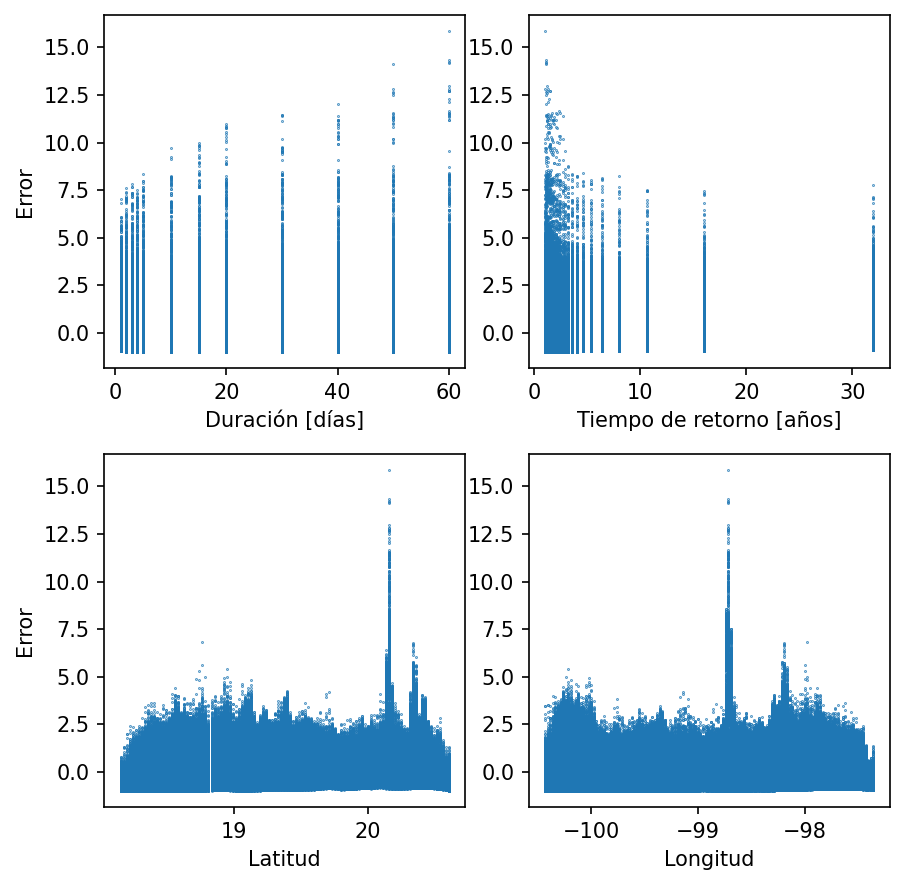

In [9]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

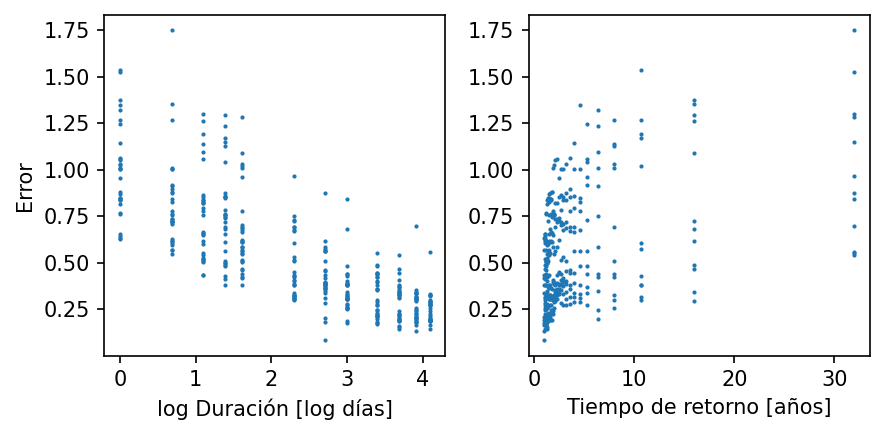

In [10]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 15
N = 15
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
ax[1].set_xlabel(f"Tiempo de retorno [años]")

fig.tight_layout()
plt.show()

In [11]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log( df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.log( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              "DURACION",
                              "TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              #"T_1",
                              "T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     816.3
Date:                Mon, 06 Nov 2023   Prob (F-statistic):          3.50e-181
Time:                        20:15:15   Log-Likelihood:                 340.51
No. Observations:                 372   AIC:                            -671.0
Df Residuals:                     367   BIC:                            -651.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8225      0.014     58.438      0.000       0.795       0.850
DURACION           0.0032      0.001      5.304      0.000       0.002       0.004
TIEMPO_RETORNO    -0.0022      0.002     -1.266      0.206      -0.006       0.001
D_1               -0.2296      0.009    -25.323      0.000      -0.247      -0.212
T_2                0.1995      0.012     16.062      0.000       0.175       0.224
==============================================================================
Omnibus:                       16.140   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.399
Skew:                           0.115   Prob(JB):                     7.57e-09
Kurtosis:                       4.536   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR", "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR", "C_TRET",
        "P_CONST",
        "P_LOG_DUR", "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #P_DUR", "P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            "LOG_DURACION", "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

# Guardamos el archivo.
df_s.to_xarray().to_netcdf("../results/comp/comp_hist_CHIRPS_reglin.nc")

print( "Media de R^2" )
print( f"{df_s.to_xarray()['ADJ_R_SQUARED'].mean().values + 0:.3f}" )
print( "Desviación estándar de R^2" )
print( f"{df_s.to_xarray()['ADJ_R_SQUARED'].std().values + 0:.3f}" )

Media de R^2
0.487
Desviación estándar de R^2
0.264


In [27]:
# Calcula la intensidad de precipitación corregida.

# Generamos las variables de manera matricial.
T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    (132 - k * 2, 112 - k * 2, 12, 31) )[:, :, :, 0:31]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    (132 - k * 2, 112 - k * 2, 31, 12) )[:, :, :, 0:12], 3, 2 ) 
B0 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["CONST"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B1 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_LOG_DUR"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )
B2 = np.tile( np.expand_dims( np.swapaxes(
    df_s.to_xarray()["C_LOG_TRET"].to_numpy(), 0, 1),
    (2, 3) ), (1, 1, 12, 31) )

# Predicción.
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_comp.drop( ["AÑO"] ).copy()
ds_corr["INTENSIDAD"] = ( list( ds_orig.dims ),
    np.swapaxes( ds_corr["INTENSIDAD"].to_numpy(), 0, 1) / ( REG + 1 ) )

# Guardamos.
ds_corr.to_netcdf("../temp/prec_hist_hist_corr.nc")

In [28]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Int64Index([20, 30, 40, 50, 60, 15, 10], dtype='int64', name='DURACION')


PROBABILIDAD
LATITUD   LONGITUD                 
18.157814 -100.429665      0.787500
          -100.405846      0.792824
          -100.382027      0.800625
          -100.358208      0.798469
          -100.334389      0.805556
...                             ...
20.606667 -99.214912       0.932292
          -99.191093       0.931250
          -99.167274       0.945312
          -99.143456       0.945312
          -99.119637       0.953125

[286 rows x 1 columns]

In [29]:
# Comparamos valores originales y corregidos.
ds_corr.to_dataframe()

INTENSIDAD  PROBABILIDAD
LATITUD   LONGITUD    DURACION TIEMPO_RETORNO                         
18.157814 -100.429665 1        1.032258         9.763186       0.96875
                               1.066667        19.431778       0.93750
                               1.103448        20.394637       0.90625
                               1.142857        23.260681       0.87500
                               1.185185        23.575718       0.84375
...                                                  ...           ...
20.606667 -97.357063  60       6.400000         9.826672       0.15625
                               8.000000         9.618169       0.12500
                               10.666667       11.432635       0.09375
                               16.000000       10.714602       0.06250
                               32.000000         10.7719       0.03125

[5319600 rows x 2 columns]

In [30]:
# Comparamos valores originales y corregidos.
ds_orig.to_dataframe()

AÑO  INTENSIDAD  PROBABILIDAD
LONGITUD    LATITUD   DURACION TIEMPO_RETORNO                                
-100.429665 18.157814 1        1.032258        2015   25.320889       0.96875
                               1.066667        2010   28.448201       0.93750
                               1.103448        2011   31.230145       0.90625
                               1.142857        2014   33.181446       0.87500
                               1.185185        2000   33.186734       0.84375
...                                             ...         ...           ...
-97.357063  20.606667 60       6.400000        2009   12.940125       0.15625
                               8.000000        2005   13.447352       0.12500
                               10.666667       2013   13.564227       0.09375
                               16.000000       1998   14.426718       0.06250
                               32.000000       1999   15.943147       0.03125

[5319600 rows x 3 columns]

In [21]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf("../results/comp/comp_hist_CHIRPS_espacial.nc")